In [1]:
import pandas as pd
from glob import glob
from barplots import barplots
from plot_keras_history import plot_history

In [2]:
histories = glob("single_gap/cnn_*/*.csv")

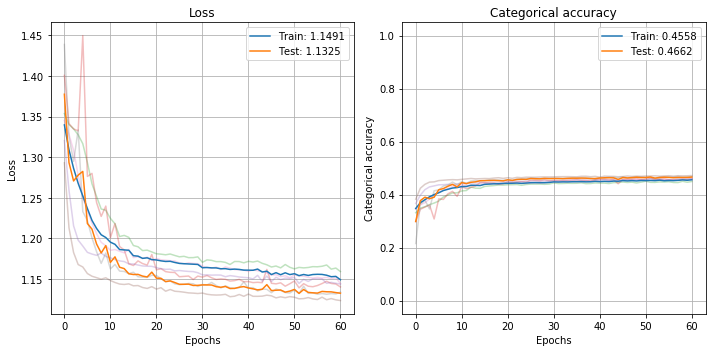

In [3]:
plot_history(histories, max_epochs="min")

In [2]:
results = pd.concat([
    pd.read_csv(path, index_col=0)
    for path in glob("reports/*.csv")
])

In [3]:
colors = {
    "cae_200": "tab:blue",
    "cae_500": "tab:blue",
    "cae_1000": "tab:blue",
    "cnn_200": "tab:orange",
    "cnn_500": "tab:orange",
    "cnn_1000": "tab:orange",
}
alphas = {
    "cae_200": 0.7,
    "cae_500": 0.4,
    "cae_1000": 1,
    "cnn_200": 0.4,
    "cnn_500": 0.7,
    "cnn_1000": 1,
}

In [4]:
task = "reconstruction"
results1 = results[results.task==task]
results1 = results1[results1.run_type!="biological validation"]
results1 = results1.drop(columns=["task", "dataset"])

In [5]:
for trained_on in results1.trained_on.unique():
    tmp = results1[results1.trained_on==trained_on].drop(
        columns=["trained_on"]
    )
    barplots(
        tmp,
        ["run_type", "target", "model"],
        path=f"barplots/{task}_{trained_on}_{{feature}}",
        show_standard_deviation=False,
        subplots=True,
        orientation="horizontal",
        plots_per_row=4,
        major_rotation=90,
        unique_minor_labels=True,
        show_legend=False,
        colors=colors,
        alphas=alphas
    )

In [6]:
task = "reconstruction"
results1 = results[results.task==task]
results1 = results1[results1.run_type=="biological validation"]
results1 = results1.drop(columns=["task", "dataset"])

for trained_on in results1.trained_on.unique():
    tmp = results1[results1.trained_on==trained_on].drop(
        columns=["trained_on"]
    )
    barplots(
        tmp,
        ["run_type", "target", "model"],
        height=4.75,
        path=f"barplots/biological_{task}_{trained_on}_{{feature}}",
        show_standard_deviation=False,
        subplots=True,
        orientation="horizontal",
        plots_per_row=4,
        unique_minor_labels=True,
        show_legend=False,
        colors=colors,
        alphas=alphas,
        major_rotation=90,
    )

In [7]:
models = ("cae", "cnn", str(1000))
for model in models:
    task = "gap_filling"
    results2 = results[results.task==task]
    results2 = results2[results2.run_type!="biological validation"]
    results2 = results2[results2.model.str.contains(model)]
    results2 = results2.drop(columns=["task", "dataset"])
    for trained_on in results2.trained_on.unique():
        tmp = results2[results2.trained_on==trained_on].drop(
            columns=["trained_on"]
        )
        barplots(
            tmp,
            ["run_type", "target", "model"],
            path=f"barplots/{model}_{task}_{trained_on}_{{feature}}",
            show_standard_deviation=False,
            subplots=True,
            orientation="horizontal",
            plots_per_row=5,
            **({"space_width":0.6} if model=="1000" else {}),
            major_rotation=90,
            unique_minor_labels=True,
            show_legend=False,
            colors=colors,
            alphas=alphas
        )

In [8]:
task = "gap_filling"
results2 = results[results.task==task]
results2 = results2[results2.run_type=="biological validation"]
results2 = results2.drop(columns=["task", "dataset"])

In [10]:
for trained_on in results2.trained_on.unique():
    tmp = results2[results2.trained_on==trained_on].drop(
        columns=["trained_on"]
    )
    barplots(
        tmp,
        ["run_type", "target", "model"],
        path=f"barplots/biological_{task}_{trained_on}_{{feature}}",
        show_standard_deviation=False,
        subplots=True,
        orientation="horizontal",
        plots_per_row=5,
        unique_minor_labels=True,
        show_legend=False,
        alphas=alphas,
        major_rotation=90,
        colors=colors
    )